In [601]:
import numpy as np
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
#conda install Basemap
#from mpl_toolkits.basemap import Basemap
from itertools import combinations
pd.set_option('display.max_columns', 20000)
import datetime

In [998]:
eq = pd.read_csv('data/03_equipment.csv', sep = ',"')

/Users/natali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [603]:
data = pd.read_csv('data/02_Data_test.csv', sep = ';')

In [604]:
positive_labels = pd.read_csv('data/01_Facts.csv', sep = ";", header = None)

We don't have any information about this number 158528852857, 158530004641 in the train data, however it is in positive labels.

In [605]:
to_delete = []
for i, row in enumerate(positive_labels.values):
    if len(data[data['msisdn'] == row[0]]) == 0:
        to_delete.append(row[0])
    if len(data[data['msisdn'] == row[1]]) == 0:
        to_delete.append(row[1])

In [606]:
to_delete

[158528852857, 158530004641]

In [607]:
positive_labels = positive_labels.drop(positive_labels[positive_labels[1].isin(to_delete)].index[0], axis = 0).reset_index(drop = True)
positive_labels = positive_labels.drop(positive_labels[positive_labels[1].isin(to_delete)].index[0], axis = 0).reset_index(drop = True)

In [608]:
data.head()

,lac,cid,msisdn,imei,event_type,tstamp,long,lat,max_dist,cell_type,start_angle,end_angle
0,5029,40798,158529599791,3.531111e+14,0,1369252800974,37.9305,55.7815,2101,OUTDOOR,220.0,280.0
1,7782,56870,158520145943,1.292900e+13,5,1369252801396,37.4239,55.7426,2,OUTDOOR,45.0,105.0
2,7794,32226,158521798391,3.519940e+14,5,1369252802013,37.7034,55.5803,1125,OUTDOOR,0.0,60.0
3,7758,33528,158537830573,3.586270e+14,0,1369252802331,37.7895,55.7042,1158,OUTDOOR,210.0,270.0
4,5060,17568,158510204039,3.524581e+14,8,1369252803586,37.1900,55.8308,500,OUTDOOR,180.0,240.0


In [609]:
len(data[data['msisdn'] == positive_labels.iloc[1][0]])

47

In [610]:
data.head(1)

,lac,cid,msisdn,imei,event_type,tstamp,long,lat,max_dist,cell_type,start_angle,end_angle
0,5029,40798,158529599791,3.531111e+14,0,1369252800974,37.9305,55.7815,2101,OUTDOOR,220.0,280.0


"Msisdn" column is how many milliseconds passed from 1970-01-01. The next function convert this column in ordinary date-time format

In [611]:
data['tstamp'] = data['tstamp'].apply(lambda x: datetime.datetime(1970, 1, 1, 0, 0) + datetime.timedelta(milliseconds = x))

In [612]:
data.head(1)

,lac,cid,msisdn,imei,event_type,tstamp,long,lat,max_dist,cell_type,start_angle,end_angle
0,5029,40798,158529599791,3.531111e+14,0,2013-05-22 20:00:00.974,37.9305,55.7815,2101,OUTDOOR,220.0,280.0


In [613]:
print("How many observations in our data set? -  {}".format(len(data)))
print("How many unique numbers (msisdn) in our data set? - {}".format(data['msisdn'].nunique()))

How many observations in our data set? -  174123
How many unique numbers (msisdn) in our data set? - 2361


In [614]:
list_of_positive_labels = []
for j in range(2):
    for i in range(len(positive_labels)):
        list_of_positive_labels.append(positive_labels.loc[i, j])

In [615]:
data_small = pd.DataFrame(columns = data.columns)
for i in list(data['msisdn'].unique()):
    if i in list_of_positive_labels:
        data_small = data_small.append(data[data['msisdn'] == i])
data_small = data_small.reset_index(drop = True)

In [616]:
data_small.head()

,lac,cid,msisdn,imei,event_type,tstamp,long,lat,max_dist,cell_type,start_angle,end_angle
0,7798,3866,158528850493,NaN,0,2013-05-22 20:00:34.051,37.6735,55.7363,403,OUTDOOR,255.0,315.0
1,7761,15621,158528850493,NaN,0,2013-05-22 20:05:32.222,37.6665,55.7385,337,OUTDOOR,170.0,230.0
2,7798,3866,158528850493,1.300201e+13,3,2013-05-22 20:05:32.299,37.6735,55.7363,403,OUTDOOR,255.0,315.0
3,7798,3866,158528850493,NaN,0,2013-05-22 20:05:52.222,37.6735,55.7363,403,OUTDOOR,255.0,315.0
4,7761,15621,158528850493,1.300201e+13,3,2013-05-22 23:10:34.644,37.6665,55.7385,337,OUTDOOR,170.0,230.0


In [617]:
len(data_small)

8136

Since cid - identificator of base station unique in terms of lac the folowing cell creates columns 'lac_cid' as a combination of cid and lac and this gives as unique location for each station

In [618]:
data_small['lac_cid'] = data_small['lac'].astype(str)  + data_small['cid'].astype(str)

Grouping by msisdn. The first column of result dataframe msisdn itself, the second column - list of all locations where this number was registered

In [619]:
group = data_small.groupby(['msisdn'], as_index=False).agg({'lac_cid':(lambda x: list(x))}).rename(columns={'msisdn':'number', 'lac_cid':'set_'})

In [620]:
len(group)

240

Creating all posible combinations of msisdn

In [621]:
df = pd.DataFrame(columns = ['number_1', 'set_1', 'number_2', 'set_2'])

for index in list(combinations(group.index, 2)):
    
    df0 = pd.DataFrame(group.loc[index[0]]).T.reset_index(drop=True)
    df1 = pd.DataFrame(group.loc[index[1]]).T.reset_index(drop=True)
    df_temp = pd.concat([df0, df1], axis = 1)
    df_temp.columns = ['number_1', 'set_1', 'number_2', 'set_2']
    df = df.append(df_temp)
df = df.set_index(pd.Index(range(len(df))))

In [590]:
for i in range(28680):
    if df.iloc[i, 0] == df.iloc[i, 2]:
        df = df.drop(i)

The first assumption is that if user holds 2 numbers the locations rigistered by base station of exactly these numbers intersect

Let's create the column 'inter' which contains the information of how much intersections for each row (pair of numbers) we have over length of the shotest list among two given (list of locations of two candidates). It's important because if the first list consists of 20 elements, and the second only of 3 but all these 3 fall into those 20, we will have only 3 intersections. By actually taking into account the fact that the  registered locations of the second number 100% the same as locations of the first number, gives us the assumption that they might have the same user (may he brings the second number rarely, but he always goes in the same places).

In [591]:
df.head()

,number_1,set_1,number_2,set_2
0,158500411793,"[50205834, 502049184, 502049184, 50209186, 502...",158500437133,"[775334177, 775334176]"
1,158500411793,"[50205834, 502049184, 502049184, 50209186, 502...",158500611579,"[77125754, 77125754, 771220486, 771220486]"
2,158500411793,"[50205834, 502049184, 502049184, 50209186, 502...",158500670731,"[508648686, 502045597, 502048679, 508648675]"
3,158500411793,"[50205834, 502049184, 502049184, 50209186, 502...",158500730293,"[775530067, 778432289, 778432289, 776537843, 7..."
4,158500411793,"[50205834, 502049184, 502049184, 50209186, 502...",158500730487,"[775522653, 775522653, 775512588, 775522653, 7..."


In [623]:
def intersect(x):
    list1 = x['set_1']
    list2 = x['set_2']
    
    min_len = min(len(list1), len(list2))
    res = []
    list_1 = list1.copy()
    for i in list_1:
        if i in list2:
            res.append(i)
            list1.remove(i)
            list2.remove(i)       
    return len(res)/(min_len+1)

In [624]:
df['inter'] = df.apply(intersect, axis =1)

The following finction returns the dictionary of possible numbers which belong to the same person. It chooses candidates by selecting maximum intersection between them

In [809]:
def find_pair(df):
    res = {}
    for number_1 in list(df['number_1'].unique()):
        value = max(df[df['number_1'] == number_1]['inter'])
        if value > 0.2:
            number_2 = df[(df['number_1'] == number_1) &(df['inter'] == value)]['number_2'].iloc[0]
            if number_2 in list(res.keys()) or number_2 in list(res.values()) or number_1 in list(res.values()):

                continue
            else:
                res[number_1] = number_2
    return res

In [794]:
res = find_pair(df)

In [710]:
positive_labels.head()

,0,1
0,158530067653,158528861653
1,158530063945,158528861599
2,158524011325,158524011355
3,158528852153,158528861475
4,158510912383,158524011019


In [819]:
for i in positive_labels[0]:
    if res.get(i):
        continue
    elif i in list(res.values()):
        res[i] = list(res.keys())[list(res.values()).index(i)]
        del res[list(res.keys())[list(res.values()).index(i)]]

In [826]:
def precision(pred, acual):
    count_all = 0
    count_positive = 0
    for i, row in enumerate(acual.values):
        if pred.get(acual.loc[i,:][0]):
            count_all += 1
            if acual.loc[i,:][1] == pred[acual.loc[i,:][0]]:
                count_positive += 1
        #if pred.get(acual.loc[i,:][1]):
            #count_all += 1
            #if acual.loc[i,:][0] == pred.get(acual.loc[i,:][1]):
                #count_positive += 1
        
        #if acual.loc[i,:][1] in list(pred.values()):
            #count_all += 1
            #if acual.loc[i,:][0] == list(pred.keys())[list(pred.values()).index(acual.loc[i,:][1])]:
                #count_positive += 1
        
        #if acual.loc[i,:][0] in list(pred.values()):
            #count_all += 1
            #if acual.loc[i,:][1] == list(pred.keys())[list(pred.values()).index(acual.loc[i,:][0])]:
                #count_positive += 1
                
    return count_positive/count_all, count_all

In [827]:
precision(res, positive_labels)

(0.8823529411764706, 68)

In [800]:
len(res)

72

In [801]:
len(positive_labels)

120

In [828]:
def recall(pred, acual):
    count_all = len(acual)
    count_positive = 0
    
    for i, row in enumerate(acual.values):
        if pred.get(acual.loc[i,:][0]):
            if acual.loc[i,:][1] == pred[acual.loc[i,:][0]]:
                count_positive += 1
        #if pred.get(acual.loc[i,:][1]):
            #if acual.loc[i,:][0] == pred.get(acual.loc[i,:][1]):
                #count_positive += 1
        #if acual.loc[i,:][1] in list(pred.values()):
            #if acual.loc[i,:][0] == list(pred.keys())[list(pred.values()).index(acual.loc[i,:][1])]:
                #count_positive += 1
        
        #if acual.loc[i,:][0] in list(pred.values()):
            #if acual.loc[i,:][1] == list(pred.keys())[list(pred.values()).index(acual.loc[i,:][0])]:
                #count_positive += 1
    return count_positive/count_all, count_positive

In [829]:
recall(res, positive_labels)

(0.5, 60)

In [440]:
positive_labels.head()

,0,1
0,158530067653,158528861653
1,158530063945,158528861599
2,158524011325,158524011355
3,158528852153,158528861475
4,158510912383,158524011019


In [441]:
pd.set_option('display.max_rows', 200)

Get rid of seconds and microseconds in date column

In [830]:
data_small.tstamp = data_small.tstamp.apply(lambda x: x.replace(second=0, microsecond=0))

In [831]:
def intersectin_time_loc(x):
    
    index_1 = x['number_1']
    index_2 = x['number_2']
    
    counter = 0
    set_1 = data_small[data_small['msisdn'] == index_1]
    set_2 = data_small[data_small['msisdn'] == index_2]
    time1, time2 = [], []
    for i in set_1['tstamp']:
        for j in set_2['tstamp']:
            if i - margin <= j <= i+margin:
                if set_1[set_1['tstamp'] == i]['lac'].iloc[0] == set_2[set_2['tstamp'] == j]['lac'].iloc[0]:
                    time1.append(i)
                    time2.append(j)
                    counter += 1
    return counter

In [832]:
len(df)

28680

In [833]:
df['intersectin_time_loc'] = df.apply(intersectin_time_loc, axis = 1)

In [875]:
def find_pair_based_on_time_loc(df):
    res_time_loc = {}
    for number_1 in list(df['number_1'].unique()):
        value = max(df[df['number_1'] == number_1]['intersectin_time_loc'])
        if value > 10:
            number_2 = df[(df['number_1'] == number_1) &(df['intersectin_time_loc'] == value)]['number_2'].iloc[0]
            if number_2 in list(res_time_loc.keys()) or number_2 in list(res_time_loc.values()) or number_1 in list(res_time_loc.values()):
                continue
            else:
                res_time_loc[number_1] = number_2
    return res_time_loc

In [876]:
time_loc = find_pair_based_on_time_loc(df)

In [877]:
for i in positive_labels[0]:
    if time_loc.get(i):
        continue
    elif i in list(time_loc.values()):
        time_loc[i] = list(time_loc.keys())[list(time_loc.values()).index(i)]
        del time_loc[list(time_loc.keys())[list(time_loc.values()).index(i)]]

In [878]:
len(time_loc)

9

In [879]:
precision(time_loc, positive_labels)

(0.7777777777777778, 9)

In [874]:
recall(time_loc, positive_labels)

(0.11666666666666667, 14)

In [451]:
len(positive_labels)

120

In [291]:
len(time_loc)

30

In [881]:
df_for_algo = df[['number_1', 'number_2', 'inter', 'intersectin_time_loc']]

In [883]:
df_for_algo['target'] = 0

/Users/natali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [924]:
df_for_algo.head()

,number_1,number_2,inter,intersectin_time_loc,target
0,158500411793,158500437133,0.0,0,0
1,158500411793,158500611579,0.0,0,0
2,158500411793,158500670731,0.0,0,0
3,158500411793,158500730293,0.0,0,0
4,158500411793,158500730487,0.0,0,0


In [939]:
new_target = []

for entry in df_for_algo.values:
    for pair in positive_labels.values:
        add=0
        if entry[0] in pair and entry[1] in pair:
            new_target.append(1)
            add=1
            break
    if add==0:
        new_target.append(0)

df_for_algo['target'] = new_target

/Users/natali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [947]:
import matplotlib.pyplot as plt
import seaborn as sns

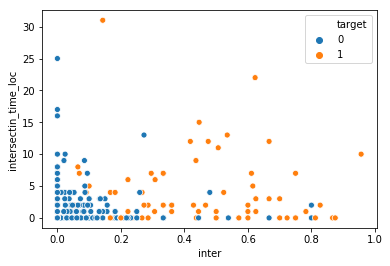

In [948]:
ax = sns.scatterplot(x="inter", y="intersectin_time_loc", hue="target", data=df_for_algo)

In [949]:
df_for_algo.to_csv('df_for_algo.csv')

Check if a person with two sim-card can have only one phone number (imei)

In [37]:
count = 0
for i, row in enumerate(positive_labels.values):
    imei_1 = data_small[data_small['msisdn'] == positive_labels.loc[i,:][0]]['msisdn'].iloc[0]
    imei_2 = data_small[data_small['msisdn'] == positive_labels.loc[i,:][1]]['msisdn'].iloc[0]
    if imei_1 == imei_2:
        count += 1
        
count

0

In [971]:
data_small['tac'] = data_small['imei'].apply(lambda x: str(x)[0:8])

In [972]:
data_small.head()

,lac,cid,msisdn,imei,event_type,tstamp,long,lat,max_dist,cell_type,start_angle,end_angle,lac_cid,tac
0,7798,3866,158528850493,NaN,0,2013-05-22 20:00:00,37.6735,55.7363,403,OUTDOOR,255.0,315.0,77983866,nan
1,7761,15621,158528850493,NaN,0,2013-05-22 20:05:00,37.6665,55.7385,337,OUTDOOR,170.0,230.0,776115621,nan
2,7798,3866,158528850493,1.300201e+13,3,2013-05-22 20:05:00,37.6735,55.7363,403,OUTDOOR,255.0,315.0,77983866,13002009
3,7798,3866,158528850493,NaN,0,2013-05-22 20:05:00,37.6735,55.7363,403,OUTDOOR,255.0,315.0,77983866,nan
4,7761,15621,158528850493,1.300201e+13,3,2013-05-22 23:10:00,37.6665,55.7385,337,OUTDOOR,170.0,230.0,776115621,13002009


In [999]:
eq.columns = ['tac', 'vendor', 'platform', 'type']

In [1000]:
eq['tac'] = eq['tac'].apply(lambda x: x[1:])

In [1001]:
eq['vendor'] = eq['vendor'].apply(lambda x: x[1:-2])

In [1002]:
eq['platform'] = eq['platform'].apply(lambda x: x[1:-2])

In [1003]:
eq['type'] = eq['type'].apply(lambda x: x[1:-3])

In [1004]:
eq.head()

,tac,vendor,platform,type
0,00100429,PROTO,Proprietary,Phone
1,00100430,PROTO,Proprietary,Phone
2,00100431,PROTO,Proprietary,Phone
3,00100432,PROTO,Proprietary,Phone
4,00100433,PROTO,Proprietary,Phone


Let see if all our observations belong to the same country(city), by depicting the coordinates of unique groups of base stations